In [18]:
import os
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import numpy as np
import json
import scanpy as sc
from functools import reduce
import seaborn as sns

In [19]:
def agg_same_string(x: pd.Series):
    return x.iloc[0]

def agg_vote(x: pd.Series):
    return x.value_counts().index[0]

def agg_cell_maxfreq_mincount(x: pd.Series):
    categorized_x = x.copy()
    categorized_x[categorized_x >= 2] = 2

    agg_value = float(categorized_x.value_counts().index[0])
    if agg_value <= 1.0:
        return agg_value
    else:
        freq = x[x > 1.0].value_counts().reset_index()
        freq = freq.sort_values(by=["count", x.name], ascending=[False, True])
        agg_value = float(freq.iloc[0]["count"])
        return agg_value
    
def agg_cell_maxfreq_maxcount(x: pd.Series):
    categorized_x = x.copy()
    categorized_x[categorized_x >= 2] = 2

    agg_value = float(categorized_x.value_counts().index[0])
    if agg_value <= 1.0:
        return agg_value
    else:
        freq = x[x > 1.0].value_counts().reset_index()
        freq = freq.sort_values(by=["count", x.name], ascending=[False, False])
        agg_value = float(freq.iloc[0]["count"])
        return agg_value
    
def agg_cell_mean_doublet(x: pd.Series):
    categorized_x = x.copy()
    categorized_x[categorized_x >= 2] = 2

    agg_value = float(categorized_x.value_counts().index[0])
    if agg_value <= 1.0:
        return agg_value
    else:
        agg_value = x[x > 1.0].mean()
        return agg_value
    
def agg_cell_max_doublet(x: pd.Series):
    categorized_x = x.copy()
    categorized_x[categorized_x >= 2] = 2

    agg_value = float(categorized_x.value_counts().index[0])
    if agg_value <= 1.0:
        return agg_value
    else:
        agg_value = x[x > 1.0].max()
        return agg_value

In [20]:
preds = []

for model in [1,2,3,4,5]:
    detection_results = glob(f"Faster-RCNN-Ensemble/img_out/for_expression/detection-results-model{model}/*.txt")

    for res_file in detection_results:
        image_id = os.path.splitext(os.path.basename(res_file))[0]
        image_set, row, col = image_id.split("_")
        image_pos = f"COL{int(col):02d}_ROW{int(row):02d}"
        
        with open(res_file, "r") as Res:
            cells = Res.readlines()
            cells = [record for record in cells if float(record.split()[1]) > 0.7]
            n_cells = len(cells)
        if n_cells == 0:
            image_class = "Missing"
        elif n_cells == 1:
            image_class = "Singlet"
        elif n_cells >= 2:
            image_class = "Doublet"
        else:
            raise ValueError("Invalid cell number")
        
        preds.append([image_id, image_set, image_pos, n_cells, image_class, model])
    
preds = pd.DataFrame(preds, columns=["image_id", "image_set", "image_pos", "pred_n_cells", "pred_image_class", "model_id"])

preds_agg = preds.groupby(["image_id", "image_set", "image_pos"])\
    .agg({"pred_image_class": agg_vote, "pred_n_cells": [agg_cell_maxfreq_maxcount, agg_cell_maxfreq_mincount, agg_cell_mean_doublet, agg_cell_max_doublet]}).reset_index()
preds_agg.columns = ["image_id", "image_set", "image_pos", "pred_image_class",
                     "pred_n_cells_maxfreq_maxn", "pred_n_cells_maxfreq_minn",
                     "pred_n_cells_mean_doubletn", "pred_n_cells_max_doubletn"]

targets = pd.read_csv("crop_target/targets.csv")
targets["image_set"] = targets["image_id"].apply(lambda x: x.split("_")[0])
targets["image_pos"] = targets["image_id"].\
    apply(lambda x: f"COL{int(x.split('_')[2]):02d}_ROW{int(x.split('_')[1]):02d}")

In [21]:
preds_loocv_img5 = []

for model in [1,2,3,4,5]:
    detection_results = glob(f"Faster-RCNN-Ensemble/img_out/loocv/Image5/detection-results-model{model}/*.txt")

    for res_file in detection_results:
        image_id = os.path.splitext(os.path.basename(res_file))[0]
        image_set, row, col = image_id.split("_")
        image_pos = f"COL{int(col):02d}_ROW{int(row):02d}"
        
        with open(res_file, "r") as Res:
            cells = Res.readlines()
            cells = [record for record in cells if float(record.split()[1]) > 0.7]
            n_cells = len(cells)
        if n_cells == 0:
            image_class = "Missing"
        elif n_cells == 1:
            image_class = "Singlet"
        elif n_cells >= 2:
            image_class = "Doublet"
        else:
            raise ValueError("Invalid cell number")
        
        preds_loocv_img5.append([image_id, image_set, image_pos, n_cells, image_class, model])
    
preds_loocv_img5 = pd.DataFrame(preds_loocv_img5, columns=["image_id", "image_set", "image_pos", "pred_n_cells", "pred_image_class", "model_id"])

preds_loocv_img5_agg = preds_loocv_img5.groupby(["image_id", "image_set", "image_pos"])\
    .agg({"pred_image_class": agg_vote, "pred_n_cells": [agg_cell_maxfreq_maxcount, agg_cell_maxfreq_mincount, agg_cell_mean_doublet, agg_cell_max_doublet]}).reset_index()
preds_loocv_img5_agg.columns = ["image_id", "image_set", "image_pos", "pred_image_class",
                     "pred_n_cells_maxfreq_maxn", "pred_n_cells_maxfreq_minn",
                     "pred_n_cells_mean_doubletn", "pred_n_cells_max_doubletn"]

In [22]:
preds_loocv_img11 = []

for model in [1,2,3,4,5]:
    detection_results = glob(f"Faster-RCNN-Ensemble/img_out/loocv/Image11/detection-results-model{model}/*.txt")

    for res_file in detection_results:
        image_id = os.path.splitext(os.path.basename(res_file))[0]
        image_set, row, col = image_id.split("_")
        image_pos = f"COL{int(col):02d}_ROW{int(row):02d}"
        
        with open(res_file, "r") as Res:
            cells = Res.readlines()
            cells = [record for record in cells if float(record.split()[1]) > 0.7]
            n_cells = len(cells)
        if n_cells == 0:
            image_class = "Missing"
        elif n_cells == 1:
            image_class = "Singlet"
        elif n_cells >= 2:
            image_class = "Doublet"
        else:
            raise ValueError("Invalid cell number")
        
        preds_loocv_img11.append([image_id, image_set, image_pos, n_cells, image_class, model])
    
preds_loocv_img11 = pd.DataFrame(preds_loocv_img11, columns=["image_id", "image_set", "image_pos", "pred_n_cells", "pred_image_class", "model_id"])

preds_loocv_img11_agg = preds_loocv_img11.groupby(["image_id", "image_set", "image_pos"])\
    .agg({"pred_image_class": agg_vote, "pred_n_cells": [agg_cell_maxfreq_maxcount, agg_cell_maxfreq_mincount, agg_cell_mean_doublet, agg_cell_max_doublet]}).reset_index()
preds_loocv_img11_agg.columns = ["image_id", "image_set", "image_pos", "pred_image_class",
                     "pred_n_cells_maxfreq_maxn", "pred_n_cells_maxfreq_minn",
                     "pred_n_cells_mean_doubletn", "pred_n_cells_max_doubletn"]

In [23]:
raw_counts_img5 = sc.read_csv("./expression/results/counts/raw_counts_img5_glevel.txt", delimiter="\t").T
raw_counts_img5.obs["n_nonzero_genes"] = (raw_counts_img5.to_df() != 0).sum(axis=1)
raw_counts_img5.obs["avg_expression"] = raw_counts_img5.to_df().mean(axis=1)
raw_counts_img5.obs["total_expression"] = raw_counts_img5.to_df().sum(axis=1)

raw_counts_img11 = sc.read_csv("./expression/results/counts/raw_counts_img11_glevel.txt", delimiter="\t").T
raw_counts_img11.obs["n_nonzero_genes"] = (raw_counts_img11.to_df() != 0).sum(axis=1)
raw_counts_img11.obs["avg_expression"] = raw_counts_img11.to_df().mean(axis=1)
raw_counts_img11.obs["total_expression"] = raw_counts_img11.to_df().sum(axis=1)

In [24]:
obs_img5 = raw_counts_img5.obs.copy()
obs_img5["image_pos"] = obs_img5.index
obs_img5 = reduce(
    lambda left,right: pd.merge(left, right, on='image_pos', how="left"), 
    [
        preds[preds["image_set"] == "Image5"],
        targets.loc[targets["image_set"] == "Image5", ["cell_num", "class", "difficult", "image_pos"]],
        obs_img5,
    ]).set_index("image_pos")
obs_img5 = obs_img5[obs_img5.difficult == False]
obs_img5.to_csv("./Figure3/data_img5.csv")

obs_img5 = raw_counts_img5.obs.copy()
obs_img5["image_pos"] = obs_img5.index
obs_img5 = reduce(
    lambda left,right: pd.merge(left, right, on='image_pos', how="left"), 
    [
        preds_loocv_img5[preds_loocv_img5["image_set"] == "Image5"],
        targets.loc[targets["image_set"] == "Image5", ["cell_num", "class", "difficult", "image_pos"]],
        obs_img5,
    ]).set_index("image_pos")
obs_img5 = obs_img5[obs_img5.difficult == False]
obs_img5.to_csv("./Figure3/data_img5_fromloocv.csv")

In [25]:
obs_img5 = raw_counts_img5.obs.copy()
obs_img5["image_pos"] = obs_img5.index
obs_img5 = reduce(
    lambda left,right: pd.merge(left, right, on='image_pos', how="left"), 
    [
        preds_agg[preds_agg["image_set"] == "Image5"],
        targets.loc[targets["image_set"] == "Image5", ["cell_num", "class", "difficult", "image_pos"]],
        obs_img5,
    ]).set_index("image_pos")
obs_img5 = obs_img5[obs_img5.difficult == False]
obs_img5.to_csv("./Figure3/data_img5_ensemble.csv")

obs_img5 = raw_counts_img5.obs.copy()
obs_img5["image_pos"] = obs_img5.index
obs_img5 = reduce(
    lambda left,right: pd.merge(left, right, on='image_pos', how="left"), 
    [
        preds_loocv_img5_agg[preds_loocv_img5_agg["image_set"] == "Image5"],
        targets.loc[targets["image_set"] == "Image5", ["cell_num", "class", "difficult", "image_pos"]],
        obs_img5,
    ]).set_index("image_pos")
obs_img5 = obs_img5[obs_img5.difficult == False]
obs_img5.to_csv("./Figure3/data_img5_fromloocv_ensemble.csv")

In [7]:
obs_img11 = raw_counts_img11.obs.copy()
obs_img11["image_pos"] = obs_img11.index
obs_img11 = reduce(
    lambda left,right: pd.merge(left, right, on='image_pos', how="left"), 
    [
        preds[preds["image_set"] == "Image11"],
        targets.loc[targets["image_set"] == "Image11", ["cell_num", "class", "difficult", "image_pos"]],
        obs_img11,
    ]).set_index("image_pos")
obs_img11 = obs_img11[obs_img11.difficult == False]
obs_img11.to_csv("./Figure3/data_img11.csv")

obs_img11 = raw_counts_img11.obs.copy()
obs_img11["image_pos"] = obs_img11.index
obs_img11 = reduce(
    lambda left,right: pd.merge(left, right, on='image_pos', how="left"), 
    [
        preds_loocv_img11[preds_loocv_img11["image_set"] == "Image11"],
        targets.loc[targets["image_set"] == "Image11", ["cell_num", "class", "difficult", "image_pos"]],
        obs_img11,
    ]).set_index("image_pos")
obs_img11 = obs_img11[obs_img11.difficult == False]
obs_img11.to_csv("./Figure3/data_img11_fromloocv.csv")

In [8]:
obs_img11 = raw_counts_img11.obs.copy()
obs_img11["image_pos"] = obs_img11.index
obs_img11 = reduce(
    lambda left,right: pd.merge(left, right, on='image_pos', how="left"), 
    [
        preds_agg[preds_agg["image_set"] == "Image11"],
        targets.loc[targets["image_set"] == "Image11", ["cell_num", "class", "difficult", "image_pos"]],
        obs_img11,
    ]).set_index("image_pos")
obs_img11 = obs_img11[obs_img11.difficult == False]
obs_img11.to_csv("./Figure3/data_img11_ensemble.csv")

obs_img11 = raw_counts_img11.obs.copy()
obs_img11["image_pos"] = obs_img11.index
obs_img11 = reduce(
    lambda left,right: pd.merge(left, right, on='image_pos', how="left"), 
    [
        preds_loocv_img11_agg[preds_loocv_img11_agg["image_set"] == "Image11"],
        targets.loc[targets["image_set"] == "Image11", ["cell_num", "class", "difficult", "image_pos"]],
        obs_img11,
    ]).set_index("image_pos")
obs_img11 = obs_img11[obs_img11.difficult == False]
obs_img11.to_csv("./Figure3/data_img11_fromloocv_ensemble.csv")

In [44]:
obs = obs_img5.reset_index()
obs[['COL', 'ROW']] = obs['image_pos'].str.split('_', expand=True)

# Extract only the numbers
obs['COL'] = obs['COL'].str.extract('(\d+)')
obs['ROW'] = obs['ROW'].str.extract('(\d+)')

# Convert the columns to numeric type
obs['COL'] = pd.to_numeric(obs['COL'])
obs['ROW'] = pd.to_numeric(obs['ROW'])

In [45]:
obs[(obs.COL > 10) & (obs["class"] == "Doublet")].shape

(6, 16)

/home/dengkw/anaconda3/envs/scrna/lib/python3.10/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/home/dengkw/anaconda3/envs/scrna/lib/python3.10/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/home/dengkw/anaconda3/envs/scrna/lib/python3.10/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/home/dengkw/anaconda3/envs/scrna/lib/python3.10/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.res

/home/dengkw/anaconda3/envs/scrna/lib/python3.10/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/home/dengkw/anaconda3/envs/scrna/lib/python3.10/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/home/dengkw/anaconda3/envs/scrna/lib/python3.10/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/home/dengkw/anaconda3/envs/scrna/lib/python3.10/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.res

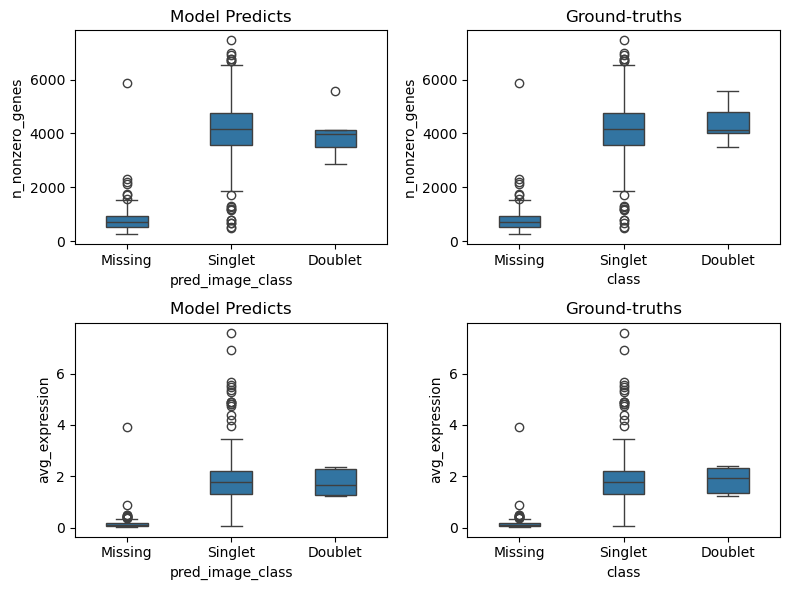

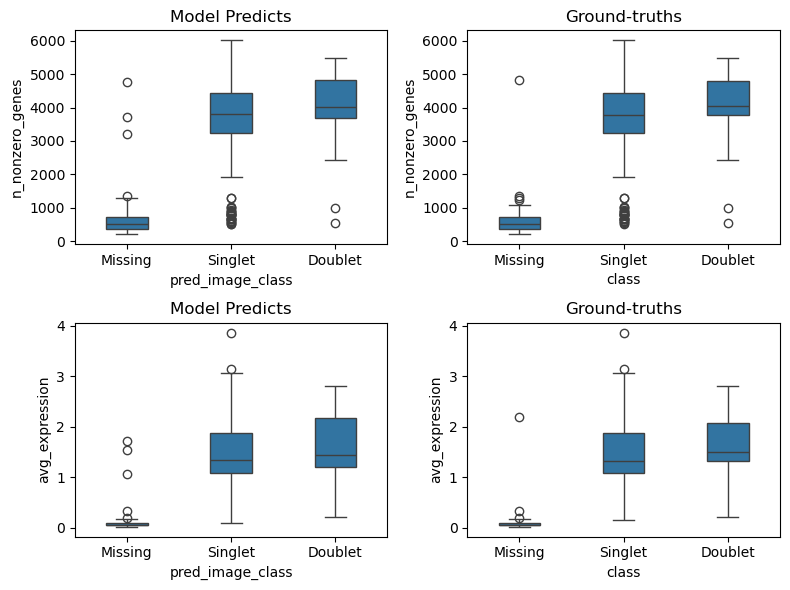

In [46]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
sns.boxplot(data=obs[obs.COL > 10], x="pred_image_class", y="n_nonzero_genes",
            width = .4, ax=axes[0][0], order=["Missing", "Singlet", "Doublet"])
sns.boxplot(data=obs[obs.COL > 10], x="pred_image_class", y="avg_expression",
            width = .4, ax=axes[1][0], order=["Missing", "Singlet", "Doublet"])
sns.boxplot(data=obs[obs.COL > 10], x="class", y="n_nonzero_genes",
            width = .4, ax=axes[0][1], order=["Missing", "Singlet", "Doublet"])
sns.boxplot(data=obs[obs.COL > 10], x="class", y="avg_expression",
            width = .4, ax=axes[1][1], order=["Missing", "Singlet", "Doublet"])
for i in range(2):
    axes[i][0].set_title("Model Predicts")
    axes[i][1].set_title("Ground-truths")

plt.tight_layout()
plt.savefig("Figure3/img5_results_H1975.png", dpi=300)

fig, axes = plt.subplots(2, 2, figsize=(8, 6))
sns.boxplot(data=obs[obs.COL <= 10], x="pred_image_class", y="n_nonzero_genes",
            width = .4, ax=axes[0][0], order=["Missing", "Singlet", "Doublet"])
sns.boxplot(data=obs[obs.COL <= 10], x="pred_image_class", y="avg_expression",
            width = .4, ax=axes[1][0], order=["Missing", "Singlet", "Doublet"])
sns.boxplot(data=obs[obs.COL <= 10], x="class", y="n_nonzero_genes",
            width = .4, ax=axes[0][1], order=["Missing", "Singlet", "Doublet"])
sns.boxplot(data=obs[obs.COL <= 10], x="class", y="avg_expression",
            width = .4, ax=axes[1][1], order=["Missing", "Singlet", "Doublet"])
for i in range(2):
    axes[i][0].set_title("Model Predicts")
    axes[i][1].set_title("Ground-truths")

plt.tight_layout()
plt.savefig("Figure3/img5_results_SUM149.png", dpi=300)